In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
def get_dataloaders(batch_size=32, img_size=224):

    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = torchvision.datasets.FashionMNIST(
        root='./data', train=True, download=True, transform=transform
    )

    test_dataset = torchvision.datasets.FashionMNIST(
        root='./data', train=False, download=True, transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader


In [3]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [4]:
def evaluate_model(model, loader):

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


In [5]:
def train_model(model, train_loader, test_loader, epochs=5, lr=1e-3, freeze_features=False):

    if freeze_features:
        for param in model.parameters():
            param.requires_grad = False

        if hasattr(model, "fc"):  # ResNet, Inception
            for param in model.fc.parameters():
                param.requires_grad = True

        elif hasattr(model, "classifier"):  # VGG, AlexNet, MobileNet
            for param in model.classifier.parameters():
                param.requires_grad = True

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    best_acc = 0
    start_time = time.time()

    for epoch in range(epochs):

        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)

            # Handle Inception auxiliary output
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        acc = evaluate_model(model, test_loader)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Loss: {avg_loss:.4f} "
              f"Test Acc: {acc:.2f}%")

        best_acc = max(best_acc, acc)

    total_time = time.time() - start_time

    print(f"\nBest Accuracy: {best_acc:.2f}%")
    print(f"Total Training Time: {total_time:.2f} sec")

    return best_acc, total_time


In [6]:
from torchinfo import summary

def show_model_summary(model, input_size=(1,3,224,224)):
    model_summary = summary(model, input_size=input_size)
    print(model_summary)

def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total Parameters: {total:,}")
    print(f"Trainable Parameters: {trainable:,}")

from ptflops import get_model_complexity_info

def compute_flops(model, input_res=(3,224,224)):

    model_cpu = model.to("cpu")

    macs, params = get_model_complexity_info(
        model_cpu,
        input_res,
        as_strings=False,
        print_per_layer_stat=False,
        verbose=False
    )

    print(f"FLOPs: {macs}")
    print(f"Params: {params}")

    model.to(device)

    gmacs = macs/1e9
    return gmacs


In [7]:
import pandas as pd
import os

RESULTS_FILE = "model_results.csv"

if not os.path.exists(RESULTS_FILE):
    df = pd.DataFrame(columns=[
        "Model",
        "Depth",
        "Accuracy",
        "Training_Time_sec",
        "Total_Params",
        "Trainable_Params",
        "FLOPs_GMACs"
    ])
    df.to_csv(RESULTS_FILE, index=False)


In [8]:
def save_results(model_name, depth, accuracy, training_time, model, flops_value):

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    new_row = {
        "Model": model_name,
        "Depth": depth,
        "Accuracy": accuracy,
        "Training_Time_sec": training_time,
        "Total_Params": total_params,
        "Trainable_Params": trainable_params,
        "FLOPs_GMACs": flops_value
    }

    df = pd.read_csv(RESULTS_FILE)
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    df.to_csv(RESULTS_FILE, index=False)

    print(f"Results saved for {model_name}")


In [9]:
import gc

def run_experiment(model, model_name, depth, epochs=3, img_size=224, batch_size=32, freeze_features=True):

    print(f"\n========== Running {model_name} ==========\n")

    train_loader, test_loader = get_dataloaders(batch_size=batch_size, img_size=img_size)
    model = model.to(device)

    show_model_summary(model, input_size=(1,3,img_size,img_size))

    acc, train_time = train_model(
        model,
        train_loader,
        test_loader,
        epochs=epochs,
        freeze_features=freeze_features
    )

    flops = compute_flops(model, input_res=(3,img_size,img_size))

    save_results(
        model_name=model_name,
        depth=depth,
        accuracy=acc,
        training_time=train_time,
        model=model,
        flops_value=flops
    )

    print(f"\nFinished {model_name}\n")

    del model
    torch.cuda.empty_cache()
    gc.collect()

In [15]:
#LeNet5

model = LeNet5()
run_experiment(model=model, model_name="LeNet5", depth=5, epochs=5, img_size=224, freeze_features=False)



========== Running LeNet5 ==========

Layer (type:depth-idx)                   Output Shape              Param #
LeNet5                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 220, 220]          456
├─AvgPool2d: 1-2                         [1, 6, 110, 110]          --
├─Conv2d: 1-3                            [1, 16, 106, 106]         2,416
├─AvgPool2d: 1-4                         [1, 16, 53, 53]           --
├─Linear: 1-5                            [1, 120]                  5,393,400
├─Linear: 1-6                            [1, 84]                   10,164
├─Linear: 1-7                            [1, 10]                   850
Total params: 5,407,286
Trainable params: 5,407,286
Non-trainable params: 0
Total mult-adds (M): 54.62
Input size (MB): 0.60
Forward/backward pass size (MB): 3.76
Params size (MB): 21.63
Estimated Total Size (MB): 25.99


100%|██████████| 1875/1875 [00:59<00:00, 31.38it/s]


Epoch [1/5] Loss: 0.4052 Test Acc: 88.24%


100%|██████████| 1875/1875 [01:02<00:00, 30.10it/s]


Epoch [2/5] Loss: 0.2568 Test Acc: 89.22%


100%|██████████| 1875/1875 [01:01<00:00, 30.56it/s]


Epoch [3/5] Loss: 0.1870 Test Acc: 89.44%


100%|██████████| 1875/1875 [01:00<00:00, 30.77it/s]


Epoch [4/5] Loss: 0.1339 Test Acc: 90.57%


100%|██████████| 1875/1875 [01:00<00:00, 30.82it/s]


Epoch [5/5] Loss: 0.0940 Test Acc: 90.48%

Best Accuracy: 90.57%
Total Training Time: 373.11 sec
FLOPs: 55561342
Params: 5407286
Results saved for LeNet5

Finished LeNet5



In [17]:
#AlexNet

model = models.alexnet(weights="IMAGENET1K_V1")
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)
run_experiment(model=model, model_name="AlexNet", depth=8, epochs=5, img_size=224, freeze_features=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\tarun/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:42<00:00, 5.73MB/s] 



========== Running AlexNet ==========

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11       

100%|██████████| 1875/1875 [01:16<00:00, 24.37it/s]


Epoch [1/5] Loss: 0.4767 Test Acc: 89.28%


100%|██████████| 1875/1875 [01:17<00:00, 24.21it/s]


Epoch [2/5] Loss: 0.3565 Test Acc: 89.51%


100%|██████████| 1875/1875 [01:18<00:00, 23.84it/s]


Epoch [3/5] Loss: 0.3287 Test Acc: 90.33%


100%|██████████| 1875/1875 [01:18<00:00, 24.03it/s]


Epoch [4/5] Loss: 0.2968 Test Acc: 91.11%


100%|██████████| 1875/1875 [01:18<00:00, 23.85it/s]


Epoch [5/5] Loss: 0.2888 Test Acc: 90.84%

Best Accuracy: 91.11%
Total Training Time: 463.38 sec
FLOPs: 712385098
Params: 54575114
Results saved for AlexNet

Finished AlexNet



In [26]:
#VGG16

model = models.vgg16(weights="IMAGENET1K_V1")
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10) 
run_experiment(model=model, model_name="VGG16", depth=16, epochs=3, img_size=224, freeze_features=True)


========== Running VGG16 ==========

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11            

100%|██████████| 1875/1875 [07:53<00:00,  3.96it/s]


Epoch [1/3] Loss: 0.6099 Test Acc: 88.96%


100%|██████████| 1875/1875 [07:54<00:00,  3.95it/s]


Epoch [2/3] Loss: 0.4583 Test Acc: 90.08%


100%|██████████| 1875/1875 [07:55<00:00,  3.95it/s]


Epoch [3/3] Loss: 0.4253 Test Acc: 89.92%

Best Accuracy: 90.08%
Total Training Time: 1625.21 sec
FLOPs: 15519169546
Params: 119586826
Results saved for VGG16

Finished VGG16



In [11]:
#RESNet50

model = models.resnet50(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, 10)
run_experiment(model=model, model_name="ResNet50", depth=50, epochs=3, img_size=224, freeze_features=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\tarun/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:16<00:00, 6.38MB/s]



========== Running ResNet50 ==========

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6          

100%|██████████| 1875/1875 [03:23<00:00,  9.22it/s]


Epoch [1/3] Loss: 0.6111 Test Acc: 82.24%


100%|██████████| 1875/1875 [03:24<00:00,  9.16it/s]


Epoch [2/3] Loss: 0.4791 Test Acc: 84.92%


100%|██████████| 1875/1875 [03:25<00:00,  9.12it/s]


Epoch [3/3] Loss: 0.4479 Test Acc: 84.20%

Best Accuracy: 84.92%
Total Training Time: 724.48 sec
FLOPs: 4130408458
Params: 20490
Results saved for ResNet50

Finished ResNet50



In [13]:
#RESNet101

model = models.resnet101(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, 10) 
run_experiment(model=model, model_name="ResNet101", depth=101, epochs=3, img_size=224, freeze_features=True)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\tarun/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:36<00:00, 4.88MB/s] 



========== Running ResNet101 ==========

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6         

100%|██████████| 1875/1875 [05:22<00:00,  5.81it/s]


Epoch [1/3] Loss: 0.6064 Test Acc: 83.26%


100%|██████████| 1875/1875 [05:22<00:00,  5.81it/s]


Epoch [2/3] Loss: 0.4829 Test Acc: 84.13%


100%|██████████| 1875/1875 [05:23<00:00,  5.80it/s]


Epoch [3/3] Loss: 0.4599 Test Acc: 82.88%

Best Accuracy: 84.13%
Total Training Time: 1137.88 sec
FLOPs: 7863101450
Params: 20490
Results saved for ResNet101

Finished ResNet101



In [15]:
#EfficientNet-B0
model = models.efficientnet_b0(weights="IMAGENET1K_V1") 
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10) 
run_experiment(model=model, model_name="EfficientNet-B0", depth=18, epochs=3, img_size=224, freeze_features=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\tarun/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 11.0MB/s]



========== Running EfficientNet-B0 ==========

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 10]                   --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         64
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         1,448
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           6,004
│    

100%|██████████| 1875/1875 [01:40<00:00, 18.72it/s]


Epoch [1/3] Loss: 0.6059 Test Acc: 85.04%


100%|██████████| 1875/1875 [01:38<00:00, 19.12it/s]


Epoch [2/3] Loss: 0.4761 Test Acc: 85.85%


100%|██████████| 1875/1875 [01:38<00:00, 19.11it/s]


Epoch [3/3] Loss: 0.4562 Test Acc: 86.33%

Best Accuracy: 86.33%
Total Training Time: 353.34 sec
FLOPs: 408928706
Params: 12810
Results saved for EfficientNet-B0

Finished EfficientNet-B0



In [17]:
#MobileNetV2
model = models.mobilenet_v2(weights="IMAGENET1K_V1") 
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10) 
run_experiment(model=model, model_name="MobileNetV2", depth=28, epochs=3, img_size=224, freeze_features=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\tarun/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:01<00:00, 11.6MB/s]



========== Running MobileNetV2 ==========

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [1, 10]                   --
├─Sequential: 1-1                                  [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                   [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         64
│    │    └─ReLU6: 3-3                             [1, 32, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 16, 112, 112]         --
│    │    └─Sequential: 3-4                        [1, 16, 112, 112]         896
│    └─InvertedResidual: 2-3                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-5                        [1, 24, 56, 56]           5,136
│    └─InvertedResidual: 2-4                       [1, 24, 56, 56]

100%|██████████| 1875/1875 [01:21<00:00, 22.91it/s]


Epoch [1/3] Loss: 0.5996 Test Acc: 84.10%


100%|██████████| 1875/1875 [01:21<00:00, 22.91it/s]


Epoch [2/3] Loss: 0.4966 Test Acc: 84.97%


100%|██████████| 1875/1875 [01:22<00:00, 22.85it/s]


Epoch [3/3] Loss: 0.4857 Test Acc: 85.01%

Best Accuracy: 85.01%
Total Training Time: 294.79 sec
FLOPs: 319031818
Params: 12810
Results saved for MobileNetV2

Finished MobileNetV2



In [20]:
#InceptionV3
model = models.inception_v3(weights="IMAGENET1K_V1") 
model.fc = nn.Linear(model.fc.in_features, 10) 
run_experiment(model=model, model_name="InceptionV3", depth=48, epochs=3, img_size=299, freeze_features=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\tarun/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:10<00:00, 10.2MB/s] 



========== Running InceptionV3 ==========

Layer (type:depth-idx)                   Output Shape              Param #
Inception3                               [1, 10]                   3,326,696
├─BasicConv2d: 1-1                       [1, 32, 149, 149]         --
│    └─Conv2d: 2-1                       [1, 32, 149, 149]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 149, 149]         64
├─BasicConv2d: 1-2                       [1, 32, 147, 147]         --
│    └─Conv2d: 2-3                       [1, 32, 147, 147]         9,216
│    └─BatchNorm2d: 2-4                  [1, 32, 147, 147]         64
├─BasicConv2d: 1-3                       [1, 64, 147, 147]         --
│    └─Conv2d: 2-5                       [1, 64, 147, 147]         18,432
│    └─BatchNorm2d: 2-6                  [1, 64, 147, 147]         128
├─MaxPool2d: 1-4                         [1, 64, 73, 73]           --
├─BasicConv2d: 1-5                       [1, 80, 73, 73]           --
│    └─Conv2d: 2-7       

100%|██████████| 1875/1875 [04:10<00:00,  7.48it/s]


Epoch [1/3] Loss: 0.7641 Test Acc: 81.76%


100%|██████████| 1875/1875 [04:13<00:00,  7.41it/s]


Epoch [2/3] Loss: 0.6506 Test Acc: 81.05%


100%|██████████| 1875/1875 [04:13<00:00,  7.38it/s]


Epoch [3/3] Loss: 0.6430 Test Acc: 82.57%

Best Accuracy: 82.57%
Total Training Time: 890.26 sec
FLOPs: 5745632042
Params: 20490
Results saved for InceptionV3

Finished InceptionV3



In [21]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("model_results.csv")
df.dtypes

Model                 object
Depth                  int64
Accuracy             float64
Training_Time_sec    float64
Total_Params           int64
Trainable_Params       int64
FLOPs_GMACs          float64
dtype: object

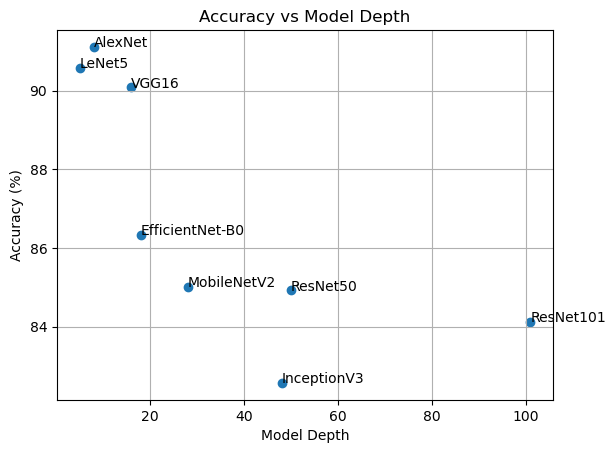

In [22]:
plt.figure()

plt.scatter(df["Depth"], df["Accuracy"])

for i in range(len(df)):
    plt.annotate(df["Model"][i],
                 (df["Depth"][i], df["Accuracy"][i]))

plt.xlabel("Model Depth")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Model Depth")
plt.grid(True)
plt.show()

On the relatively simple Fashion-MNIST dataset, shallow architectures such as LeNet-5 and AlexNet performed comparably or better than deeper architectures like ResNet-101 and InceptionV3. This suggests that increasing model depth does not necessarily yield performance gains for low-complexity datasets. Furthermore, freezing pretrained feature extractors limited the ability of deeper models to adapt to grayscale data.

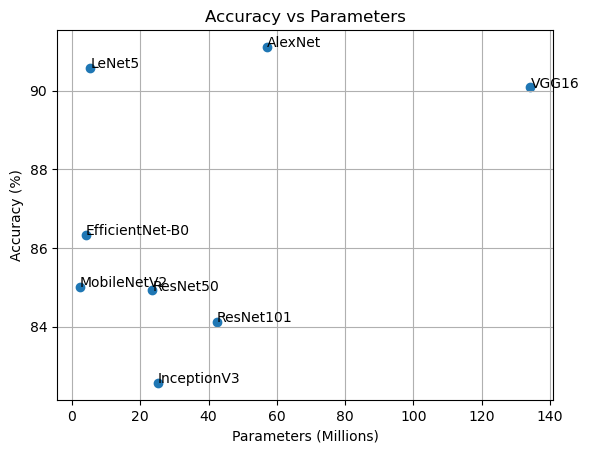

In [23]:
plt.figure()

params_millions = df["Total_Params"] / 1e6

plt.scatter(params_millions, df["Accuracy"])

for i in range(len(df)):
    plt.annotate(df["Model"][i],
                 (params_millions[i], df["Accuracy"][i]))

plt.xlabel("Parameters (Millions)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Parameters")
plt.grid(True)
plt.show()


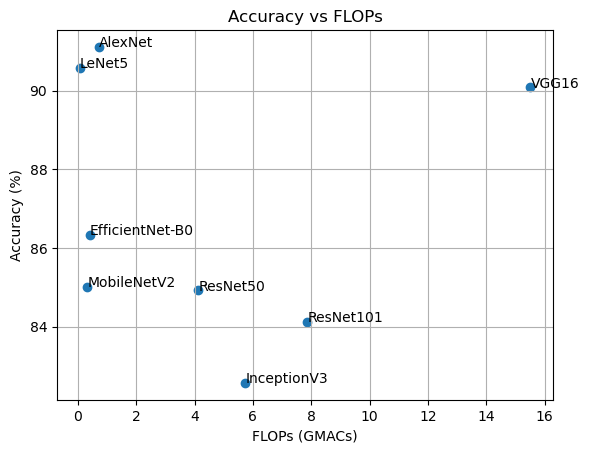

In [24]:
plt.figure()

plt.scatter(df["FLOPs_GMACs"], df["Accuracy"])

for i in range(len(df)):
    plt.annotate(df["Model"][i],
                 (df["FLOPs_GMACs"][i], df["Accuracy"][i]))

plt.xlabel("FLOPs (GMACs)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs FLOPs")
plt.grid(True)
plt.show()
